In [ ]:
"""
Combined file with all neural network models adapted to use ModuleDict,
NetworkMonitor for tracking activations and gradients, and wandb for logging experiments.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
import wandb  # Import wandb for logging experiments

###########################################
# Utility Functions and Custom Layers
###########################################

def get_activation(activation_name):
    """
    Returns the activation function based on name.
    
    Parameters:
        activation_name (str): Name of the activation function.
        
    Returns:
        nn.Module: PyTorch activation module.
    """
    activations = {
        'relu': nn.ReLU(inplace=False),  # Use inplace=False for compatibility with hooks
        'leaky_relu': nn.LeakyReLU(0.1, inplace=False),
        'tanh': nn.Tanh(),
        'sigmoid': nn.Sigmoid(),
        'gelu': nn.GELU(),
        'elu': nn.ELU(inplace=False),
        'selu': nn.SELU(inplace=False),
        'none': nn.Identity()
    }
    
    if activation_name.lower() not in activations:
        raise ValueError(f"Activation {activation_name} not supported. "
                         f"Choose from: {list(activations.keys())}")
    
    return activations[activation_name.lower()]

def get_normalization(norm_name, num_features, affine=True):
    """
    Returns the normalization layer based on name.
    
    Parameters:
        norm_name (str): Name of the normalization ('batch', 'layer', etc.)
        num_features (int): Number of features for the normalization layer.
        affine (bool): Whether the normalization layer should have learnable parameters.
        
    Returns:
        nn.Module: PyTorch normalization module or None.
    """
    if norm_name is None:
        return None
        
    normalizations = {
        'batch': nn.BatchNorm1d(num_features, affine=affine),
        'batch2d': nn.BatchNorm2d(num_features, affine=affine),
        'layer': nn.LayerNorm(num_features, elementwise_affine=affine),
        'instance': nn.InstanceNorm1d(num_features, affine=affine),
        'instance2d': nn.InstanceNorm2d(num_features, affine=affine),
        'group': nn.GroupNorm(min(32, num_features), num_features, affine=affine),
        'none': nn.Identity()
    }
    
    norm_key = str(norm_name).lower()
    if norm_key not in normalizations:
        raise ValueError(f"Normalization {norm_name} not supported. "
                         f"Choose from: {list(normalizations.keys())}")
    
    return normalizations[norm_key]


class MLP(nn.Module):
    def __init__(self, 
                 input_size=784, 
                 hidden_sizes=[512, 256, 128], 
                 output_size=10, 
                 activation='relu',
                 dropout_p=0.0,
                 normalization=None,
                 norm_after_activation=False,
                 bias=True,
                 normalization_affine=True):
        """
        Fully connected MLP that supports various activations and normalizations.
        
        Parameters:
            input_size (int): Dimensionality of input features.
            hidden_sizes (list): List of hidden layer dimensions.
            output_size (int): Number of output classes.
            activation (str): Activation function to use.
            dropout_p (float): Dropout probability (0 to disable).
            normalization (str): Normalization to use ('batch', 'layer', or None).
            norm_after_activation (bool): If True, apply normalization after activation.
            bias (bool): Whether to include bias terms in linear layers.
            normalization_affine (bool): Whether normalization layers have learnable parameters.
        """
        super(MLP, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.norm_after_activation = norm_after_activation
        
        self.layers = nn.ModuleDict()
        in_features = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            self.layers[f'linear_{i}'] = nn.Linear(in_features, hidden_size, bias=bias)
            
            if norm_after_activation:
                self.layers[f'act_{i}'] = get_activation(activation)
                if normalization:
                    self.layers[f'norm_{i}'] = get_normalization(normalization, hidden_size, affine=normalization_affine)
            else:
                if normalization:
                    self.layers[f'norm_{i}'] = get_normalization(normalization, hidden_size, affine=normalization_affine)
                self.layers[f'act_{i}'] = get_activation(activation)
            
            if dropout_p > 0:
                self.layers[f'drop_{i}'] = nn.Dropout(dropout_p)
            
            in_features = hidden_size
        
        self.layers['out'] = nn.Linear(in_features, output_size, bias=bias)
        
    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        
        for k, l in self.layers.items():
            x = l(x)
        
        return x


###########################################
#  CNN
###########################################

class CNN(nn.Module):
    def __init__(self, 
                 in_channels=3,
                 conv_channels=[64, 128, 256], 
                 kernel_sizes=[3, 3, 3],
                 strides=[1, 1, 1],
                 paddings=[1, 1, 1],
                 fc_hidden_units=[512],
                 num_classes=10, 
                 input_size=32,
                 activation='relu',
                 dropout_p=0.0,
                 pool_type='max',
                 pool_size=2,
                 use_batchnorm=True,
                 norm_after_activation=False,
                 normalization_affine=True):
        """
         CNN with layers, activations, and normalizations.
        
        Parameters:
            in_channels (int): Number of input channels.
            conv_channels (list): List of convolutional layer output channels.
            kernel_sizes (list): List of kernel sizes for each conv layer.
            strides (list): List of stride values for each conv layer.
            paddings (list): List of padding values for each conv layer.
            fc_hidden_units (list): List of hidden units for fully connected layers.
            num_classes (int): Number of output classes.
            input_size (int): Height/width of the input images.
            activation (str): Activation function to use.
            dropout_p (float): Dropout probability.
            pool_type (str): Type of pooling ('max', 'avg', or None).
            pool_size (int): Size of the pooling window.
            use_batchnorm (bool): Whether to use batch normalization.
            norm_after_activation (bool): Whether to apply normalization after activation.
            normalization_affine (bool): Whether normalization layers have learnable parameters.
        """
        super(CNN, self).__init__()
        
        assert len(conv_channels) == len(kernel_sizes) == len(strides) == len(paddings), \
            "Convolutional parameters must have the same length"
        
        self.norm_after_activation = norm_after_activation
        
        self.layers = nn.ModuleDict()
        
        channels = in_channels
        for i, (out_channels, kernel_size, stride, padding) in enumerate(
                zip(conv_channels, kernel_sizes, strides, paddings)):
            self.layers[f'conv_{i}'] = nn.Conv2d(channels, out_channels, kernel_size, stride, padding)
            
            if use_batchnorm:
                self.layers[f'norm_{i}'] = get_normalization('batch2d', out_channels, affine=normalization_affine)
            
            self.layers[f'act_{i}'] = get_activation(activation)
            
            if pool_type == 'max':
                self.layers[f'pool_{i}'] = nn.MaxPool2d(pool_size, pool_size)
            elif pool_type == 'avg':
                self.layers[f'pool_{i}'] = nn.AvgPool2d(pool_size, pool_size)
            
            channels = out_channels
        
        num_pools = len(conv_channels) if pool_type in ['max', 'avg'] else 0
        final_size = input_size // (pool_size ** num_pools)
        self.flattened_size = conv_channels[-1] * final_size * final_size
        
        self.layers['flatten'] = nn.Flatten()
        
        fc_input_size = self.flattened_size
        for i, hidden_units in enumerate(fc_hidden_units):
            self.layers[f'fc_{i}'] = nn.Linear(fc_input_size, hidden_units)
            self.layers[f'fc_act_{i}'] = get_activation(activation)
            
            if dropout_p > 0:
                self.layers[f'fc_dropout_{i}'] = nn.Dropout(dropout_p)
                
            fc_input_size = hidden_units
        
        self.layers['output'] = nn.Linear(fc_input_size, num_classes)
        
        self.num_conv_layers = len(conv_channels)
        self.num_fc_layers = len(fc_hidden_units)
        self.use_batchnorm = use_batchnorm
        self.has_pool = pool_type in ['max', 'avg']
        self.dropout_p = dropout_p
    
    def forward(self, x):
        for i in range(self.num_conv_layers):
            x = self.layers[f'conv_{i}'](x)
            
            if self.use_batchnorm and not self.norm_after_activation:
                if f'norm_{i}' in self.layers:
                    x = self.layers[f'norm_{i}'](x)
            
            x = self.layers[f'act_{i}'](x)
            
            if self.use_batchnorm and self.norm_after_activation:
                if f'norm_{i}' in self.layers:
                    x = self.layers[f'norm_{i}'](x)
            
            if self.has_pool and f'pool_{i}' in self.layers:
                x = self.layers[f'pool_{i}'](x)
        
        x = self.layers['flatten'](x)
        
        for i in range(self.num_fc_layers):
            x = self.layers[f'fc_{i}'](x)
            x = self.layers[f'fc_act_{i}'](x)
            
            if self.dropout_p > 0 and f'fc_dropout_{i}' in self.layers:
                x = self.layers[f'fc_dropout_{i}'](x)
        
        x = self.layers['output'](x)
        
        return x


###########################################
# ResNet
###########################################

class BasicBlock(nn.Module):
    """Basic ResNet block with activation and normalization."""
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1, activation='relu', 
                 use_batchnorm=True, norm_after_activation=False, downsample=None,
                 normalization_affine=True):
        super(BasicBlock, self).__init__()
        
        self.norm_after_activation = norm_after_activation
        self.layers = nn.ModuleDict()
        
        self.layers['conv1'] = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, 
                                        padding=1, bias=not use_batchnorm)
        
        if use_batchnorm:
            self.layers['bn1'] = get_normalization('batch2d', planes, affine=normalization_affine)
        
        self.layers['activation'] = get_activation(activation)
        
        self.layers['conv2'] = nn.Conv2d(planes, planes, kernel_size=3, stride=1, 
                                        padding=1, bias=not use_batchnorm)
        
        if use_batchnorm:
            self.layers['bn2'] = get_normalization('batch2d', planes, affine=normalization_affine)
        
        if downsample is not None:
            self.layers['downsample'] = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.layers['conv1'](x)
        
        if 'bn1' in self.layers and not self.norm_after_activation:
            out = self.layers['bn1'](out)
        
        out = self.layers['activation'](out)
        
        if 'bn1' in self.layers and self.norm_after_activation:
            out = self.layers['bn1'](out)
            
        out = self.layers['conv2'](out)
        
        if 'bn2' in self.layers and not self.norm_after_activation:
            out = self.layers['bn2'](out)
            
        if 'downsample' in self.layers:
            identity = self.layers['downsample'](x)
            
        out = out + identity
        out = self.layers['activation'](out)
        
        if 'bn2' in self.layers and self.norm_after_activation:
            out = self.layers['bn2'](out)
            
        return out


class ResNet(nn.Module):
    """
     ResNet architecture for continual learning experiments.
    """
    def __init__(self, 
                 block=BasicBlock,
                 layers=[2, 2, 2, 2],
                 num_classes=10,
                 in_channels=3,
                 base_channels=64,
                 activation='relu',
                 dropout_p=0.0,
                 use_batchnorm=True,
                 norm_after_activation=False,
                 normalization_affine=True):
        super(ResNet, self).__init__()
        
        self.use_batchnorm = use_batchnorm
        self.norm_after_activation = norm_after_activation
        self.in_planes = base_channels
        
        self.layers = nn.ModuleDict()
        
        self.layers['conv1'] = nn.Conv2d(in_channels, base_channels, kernel_size=3, 
                                        stride=1, padding=1, bias=not use_batchnorm)
        
        if use_batchnorm:
            self.layers['bn1'] = get_normalization('batch2d', base_channels, affine=normalization_affine)
        
        self.layers['activation'] = get_activation(activation)
        
        self._make_layer(block, base_channels, layers[0], stride=1, 
                        activation=activation, use_batchnorm=use_batchnorm, 
                        norm_after_activation=norm_after_activation, 
                        layer_name='layer1',
                        normalization_affine=normalization_affine)
        self._make_layer(block, base_channels*2, layers[1], stride=2, 
                        activation=activation, use_batchnorm=use_batchnorm, 
                        norm_after_activation=norm_after_activation, 
                        layer_name='layer2',
                        normalization_affine=normalization_affine)
        self._make_layer(block, base_channels*4, layers[2], stride=2, 
                        activation=activation, use_batchnorm=use_batchnorm,
                        norm_after_activation=norm_after_activation, 
                        layer_name='layer3',
                        normalization_affine=normalization_affine)
        self._make_layer(block, base_channels*8, layers[3], stride=2, 
                        activation=activation, use_batchnorm=use_batchnorm,
                        norm_after_activation=norm_after_activation, 
                        layer_name='layer4',
                        normalization_affine=normalization_affine)
        
        self.layers['avgpool'] = nn.AdaptiveAvgPool2d((1, 1))
        self.layers['flatten'] = nn.Flatten()
        
        if dropout_p > 0:
            self.layers['dropout'] = nn.Dropout(dropout_p)
        
        self.layers['fc'] = nn.Linear(base_channels*8*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        self.num_layers = len(layers)
        self.blocks_per_layer = layers
                
    def _make_layer(self, block, planes, num_blocks, stride=1, activation='relu', 
                    use_batchnorm=True, norm_after_activation=False, layer_name='layer',
                    normalization_affine=True):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample_layers = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, 
                         kernel_size=1, stride=stride, bias=not use_batchnorm)
            )
            
            if use_batchnorm:
                downsample_layers.add_module('1', get_normalization('batch2d', planes * block.expansion, affine=normalization_affine))
                
            downsample = downsample_layers
        
        self.layers[f'{layer_name}_block0'] = block(
            self.in_planes, planes, stride, activation, 
            use_batchnorm, norm_after_activation, downsample,
            normalization_affine=normalization_affine
        )
        
        self.in_planes = planes * block.expansion
        
        for i in range(1, num_blocks):
            self.layers[f'{layer_name}_block{i}'] = block(
                self.in_planes, planes, 1, activation, 
                use_batchnorm, norm_after_activation,
                normalization_affine=normalization_affine
            )
        
    def forward(self, x):
        x = self.layers['conv1'](x)
        
        if self.use_batchnorm and not self.norm_after_activation:
            if 'bn1' in self.layers:
                x = self.layers['bn1'](x)
                
        x = self.layers['activation'](x)
        
        if self.use_batchnorm and self.norm_after_activation:
            if 'bn1' in self.layers:
                x = self.layers['bn1'](x)
        
        for layer_idx in range(1, self.num_layers + 1):
            for block_idx in range(self.blocks_per_layer[layer_idx - 1]):
                block_name = f'layer{layer_idx}_block{block_idx}'
                x = self.layers[block_name](x)
        
        x = self.layers['avgpool'](x)
        x = self.layers['flatten'](x)
        
        if 'dropout' in self.layers:
            x = self.layers['dropout'](x)
            
        x = self.layers['fc'](x)
            
        return x


###########################################
# ViT Components
###########################################

class Attention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, dim, n_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % n_heads == 0
        self.n_heads = n_heads
        head_dim = dim // n_heads
        self.scale = head_dim ** -0.5

        self.layers = nn.ModuleDict({
            'qkv': nn.Linear(dim, dim * 3, bias=qkv_bias),
            'attn_drop': nn.Dropout(attn_drop),
            'proj': nn.Linear(dim, dim),
            'proj_drop': nn.Dropout(proj_drop)
        })

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.layers['qkv'](x).reshape(B, N, 3, self.n_heads, C // self.n_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.layers['attn_drop'](attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.layers['proj'](x)
        x = self.layers['proj_drop'](x)
        return x


class TransformerMLP(nn.Module):
    """MLP module with activation."""
    def __init__(self, in_features, hidden_features, out_features, 
                 activation='gelu', drop=0.):
        super().__init__()
        
        self.layers = nn.ModuleDict({
            'fc1': nn.Linear(in_features, hidden_features),
            'act': get_activation(activation),
            'drop1': nn.Dropout(drop) if drop > 0 else nn.Identity(),
            'fc2': nn.Linear(hidden_features, out_features),
            'drop2': nn.Dropout(drop) if drop > 0 else nn.Identity()
        })

    def forward(self, x):
        x = self.layers['fc1'](x)
        x = self.layers['act'](x)
        x = self.layers['drop1'](x)
        x = self.layers['fc2'](x)
        x = self.layers['drop2'](x)
        return x

class PatchEmbedding(nn.Module):
    """
    Image to Patch Embedding for Vision Transformer.
    Adapted to work with ModuleDict and NetworkMonitor.
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.layers = nn.ModuleDict({
            'proj': nn.Conv2d(
                in_channels,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            )
        })

    def forward(self, x):
        x = self.layers['proj'](x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        return x
        
class TransformerBlock(nn.Module):
    """Transformer block with components."""
    def __init__(self, dim, n_heads, mlp_ratio=4., qkv_bias=True, drop=0., 
                 attn_drop=0., activation='gelu', normalization='layer',
                 normalization_affine=True):
        super().__init__()
        
        self.layers = nn.ModuleDict({
            'norm1': get_normalization(normalization, dim, affine=normalization_affine),
            'attn': Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, 
                             attn_drop=attn_drop, proj_drop=drop),
            'norm2': get_normalization(normalization, dim, affine=normalization_affine),
            'mlp': TransformerMLP(dim, int(dim * mlp_ratio), dim, 
                       activation=activation, drop=drop)
        })

    def forward(self, x):
        norm_x = self.layers['norm1'](x)
        attn_out = self.layers['attn'](norm_x)
        x = x + attn_out
        
        norm_x = self.layers['norm2'](x)
        mlp_out = self.layers['mlp'](norm_x)
        x = x + mlp_out
            
        return x


class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model with architecture.
    """
    def __init__(self, 
                 img_size=32, 
                 patch_size=4, 
                 in_channels=3, 
                 num_classes=10, 
                 embed_dim=192,
                 depth=12, 
                 n_heads=8, 
                 mlp_ratio=4., 
                 qkv_bias=True, 
                 drop_rate=0.1,
                 attn_drop_rate=0.0,
                 activation='gelu',
                 normalization='layer',
                 normalization_affine=True):
        super().__init__()
        
        self.layers = nn.ModuleDict()
        
        self.layers['patch_embed'] = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.layers['patch_embed'].n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        
        self.layers['pos_drop'] = nn.Dropout(drop_rate)

        for i in range(depth):
            self.layers[f'block_{i}'] = TransformerBlock(
                embed_dim, n_heads, mlp_ratio, qkv_bias, 
                drop_rate, attn_drop_rate, activation, normalization,
                normalization_affine=normalization_affine
            )

        self.layers['norm'] = get_normalization(normalization, embed_dim, affine=normalization_affine)
        self.layers['head'] = nn.Linear(embed_dim, num_classes)

        self._init_weights()
        self.depth = depth

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = self.layers['patch_embed'](x)
        
        B = x.shape[0]
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        
        x = x + self.pos_embed
        x = self.layers['pos_drop'](x)

        for i in range(self.depth):
            x = self.layers[f'block_{i}'](x)
        
        x = self.layers['norm'](x)
        x = x[:, 0]
        x = self.layers['head'](x)
            
        return x


###########################################
# NetworkMonitor Class with Enhanced Control
###########################################

class NetworkMonitor:
    def __init__(self, model, filter_func=None):
        """
        Initialize the network monitor.
        
        Parameters:
            model: The neural network model to monitor.
            filter_func: Function that takes a layer name and returns 
                         True if the layer should be monitored.
        """
        self.model = model
        self.filter_func = filter_func if filter_func is not None else lambda name: True
        self.activations = defaultdict(list)
        self.gradients = defaultdict(list)
        self.fwd_hooks = []
        self.bwd_hooks = []
        self.hooks_active = False
        
    def set_filter(self, filter_func):
        was_active = self.hooks_active
        if was_active:
            self.remove_hooks()
        self.filter_func = filter_func if filter_func is not None else lambda name: True
        if was_active:
            self.register_hooks()
        
    def register_hooks(self):
        if not self.hooks_active:
            for name, module in self.model.named_modules():
                if name != '' and self.filter_func(name):
                    def make_fwd_hook(name=name):
                        def hook(module, input, output):
                            self.activations[f"{name}"].append(output.clone().detach().cpu())
                        return hook
                    
                    def make_bwd_hook(name=name):
                        def hook(module, grad_input, grad_output):
                            if len(grad_output) > 0 and grad_output[0] is not None:
                                self.gradients[f"{name}"].append(grad_output[0].clone().detach().cpu())
                            return grad_input
                        return hook
                    
                    h1 = module.register_forward_hook(make_fwd_hook())
                    h2 = module.register_full_backward_hook(make_bwd_hook())
                    self.fwd_hooks.append(h1)
                    self.bwd_hooks.append(h2)
            
            self.hooks_active = True
    
    def remove_hooks(self):
        if self.hooks_active:
            for h in self.fwd_hooks + self.bwd_hooks:
                h.remove()
            self.fwd_hooks = []
            self.bwd_hooks = []
            self.hooks_active = False
        
    def clear_data(self):
        self.activations = defaultdict(list)
        self.gradients = defaultdict(list)
        
    def get_latest_activations(self):
        latest_acts = {}
        for name, acts_list in self.activations.items():
            if acts_list:
                latest_acts[name] = acts_list[-1]
        return latest_acts
    
    def get_latest_gradients(self):
        latest_grads = {}
        for name, grads_list in self.gradients.items():
            if grads_list:
                latest_grads[name] = grads_list[-1]
        return latest_grads

###########################################
# Utility Functions
###########################################

def flatten_activations(layer_act):
    shape = layer_act.shape
    if len(shape) == 4:
        return layer_act.permute(0, 2, 3, 1).contiguous().view(-1, shape[1])
    elif len(shape) == 3:
        return layer_act.contiguous().view(-1, shape[2])
    else:
        return layer_act.view(-1, shape[1])

###########################################
# Metric Functions 
###########################################

def measure_dead_neurons(layer_act, dead_threshold=0.95):
    flattened_act = flatten_activations(layer_act)
    is_zero = (flattened_act.abs() < 1e-7)
    frac_zero_per_neuron = is_zero.float().mean(dim=0)
    dead_mask = (frac_zero_per_neuron > dead_threshold)
    dead_fraction = dead_mask.float().mean().item()
    return dead_fraction

def measure_duplicate_neurons(layer_act, corr_threshold=0.90):
    flattened_act = flatten_activations(layer_act)
    flattened_act = flattened_act.t()  
    flattened_act = torch.nn.functional.normalize(flattened_act, p=2, dim=1)
    similarity_matrix = torch.matmul(flattened_act, flattened_act.t())
    upper_tri_mask = torch.triu(torch.ones_like(similarity_matrix), diagonal=1).bool()
    dup_pairs = (similarity_matrix > corr_threshold) & upper_tri_mask
    neuron_is_dup = dup_pairs.any(dim=1)
    fraction_dup = neuron_is_dup.float().mean().item()
    return fraction_dup

def measure_effective_rank(layer_act, svd_sample_size=1024):
    flattened_act = flatten_activations(layer_act)
    N = flattened_act.shape[0]
    if N > svd_sample_size:
        idx = torch.randperm(N)[:svd_sample_size]
        flattened_act = flattened_act[idx]
    U, S, Vt = torch.linalg.svd(flattened_act, full_matrices=False)
    S_sum = S.sum()
    if S_sum < 1e-9:
        return 0.0
    p = S / S_sum
    p_log_p = p * torch.log(p + 1e-12)
    eff_rank = torch.exp(-p_log_p.sum()).item()
    return eff_rank

def measure_stable_rank(layer_act, sample_size=1024, use_gram=True):
    flattened_act = flatten_activations(layer_act)
    N, D = flattened_act.shape
    if N > sample_size:
        idx = torch.randperm(N)[:sample_size]
        flattened_act = flattened_act[idx]
        N = sample_size
    flattened_act = flattened_act - flattened_act.mean(dim=0, keepdim=True)
    if use_gram or D < N:
        frob_norm_sq = torch.sum(flattened_act**2).item()
        gram = torch.matmul(flattened_act.t(), flattened_act)
        trace_gram_squared = torch.sum(gram**2).item()
        if trace_gram_squared < 1e-9:
            return 0.0
        stable_rank = (frob_norm_sq**2) / trace_gram_squared
    else:
        cov = torch.matmul(flattened_act, flattened_act.t())
        trace_cov = torch.trace(cov).item()
        trace_cov_squared = torch.sum(cov**2).item()
        if trace_cov_squared < 1e-9:
            return 0.0
        stable_rank = (trace_cov**2) / trace_cov_squared
    return stable_rank

###########################################
# Analysis with Single Monitor
###########################################

def analyze_fixed_batch(model, monitor, fixed_batch, fixed_targets=None, 
                        criterion=None, dead_threshold=0.95, 
                        corr_threshold=0.99, device='cpu'):
    if fixed_batch.device != device:
        fixed_batch = fixed_batch.to(device)
    if fixed_targets is not None and fixed_targets.device != device:
        fixed_targets = fixed_targets.to(device)
    
    hooks_were_active = monitor.hooks_active
    monitor.register_hooks()
    model.eval()
    
    with torch.set_grad_enabled(criterion is not None):
        outputs = model(fixed_batch)
        if criterion is not None and fixed_targets is not None:
            loss = criterion(outputs, fixed_targets)
            loss.backward()
    
    metrics = {}
    latest_acts = monitor.get_latest_activations()
    
    for layer_name, act in latest_acts.items():
        if not isinstance(act, torch.Tensor) or \
           layer_name.startswith('dropout') or 'flatten' in layer_name or 'shortcut' in layer_name:
            continue
        
        dead_frac = measure_dead_neurons(act, dead_threshold)
        dup_frac = measure_duplicate_neurons(act, corr_threshold)
        eff_rank = measure_effective_rank(act)
        stable_rank = measure_stable_rank(act)
        
        metrics[layer_name] = {
            'dead_fraction': dead_frac,
            'dup_fraction': dup_frac,
            'eff_rank': eff_rank,
            'stable_rank': stable_rank
        }
    
    if not hooks_were_active:
        monitor.remove_hooks()
    
    return metrics

###########################################
# Training and Evaluation Functions
###########################################

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_cifar10_data(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    train_indices = list(range(500))
    fixed_train_set = Subset(trainset, train_indices)
    fixed_trainloader = DataLoader(fixed_train_set, batch_size=100, shuffle=False)
    
    val_indices = list(range(500))
    fixed_val_set = Subset(testset, val_indices)
    fixed_valloader = DataLoader(fixed_val_set, batch_size=100, shuffle=False)
    
    return trainloader, testloader, fixed_trainloader, fixed_valloader


def get_cifar10_data_with_class_selection(batch_size=128, sample_classes=None):
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    
    if sample_classes:
        class_mapping = {original_class: i for i, original_class in enumerate(sample_classes)}
        
        train_data = []
        train_targets = []
        for image, label in trainset:
            if label in sample_classes:
                new_label = class_mapping[label]
                train_data.append(image)
                train_targets.append(new_label)
        
        test_data = []
        test_targets = []
        for image, label in testset:
            if label in sample_classes:
                new_label = class_mapping[label]
                test_data.append(image)
                test_targets.append(new_label)
        
        from torch.utils.data import TensorDataset
        trainset = TensorDataset(torch.stack(train_data), torch.tensor(train_targets))
        testset = TensorDataset(torch.stack(test_data), torch.tensor(test_targets))
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    from torch.utils.data import Subset
    fixed_train_set = Subset(trainset, range(min(500, len(trainset))))
    fixed_trainloader = DataLoader(fixed_train_set, batch_size=batch_size, shuffle=False)
    
    fixed_val_set = Subset(testset, range(min(500, len(testset))))
    fixed_valloader = DataLoader(fixed_val_set, batch_size=batch_size, shuffle=False)
    
    return trainloader, testloader, fixed_trainloader, fixed_valloader

def train_with_separate_monitors(model, trainloader, testloader, fixed_trainloader, fixed_valloader,
                                 train_monitor, val_monitor, learning_rate=0.001,
                                 num_epochs=20, metrics_frequency=100, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_accs = []
    
    training_metrics_history = defaultdict(lambda: defaultdict(list))
    validation_metrics_history = defaultdict(lambda: defaultdict(list))
    step_history = []
    
    fixed_train_batch, fixed_train_targets = next(iter(fixed_trainloader))
    fixed_val_batch, fixed_val_targets = next(iter(fixed_valloader))
    
    fixed_train_batch, fixed_train_targets = fixed_train_batch.to(device), fixed_train_targets.to(device)
    fixed_val_batch, fixed_val_targets = fixed_val_batch.to(device), fixed_val_targets.to(device)
    
    print("Measuring baseline metrics before training...")
    
    train_metrics = analyze_fixed_batch(model, train_monitor, fixed_train_batch, fixed_train_targets, criterion, device=device)
    val_metrics = analyze_fixed_batch(model, val_monitor, fixed_val_batch, device=device)
    
    print("\n=== Training Batch Metrics (before training) ===")
    for layer_name in train_metrics.keys():
        metrics = train_metrics[layer_name]
        print(f"{layer_name:15}: Dead: {metrics['dead_fraction']:8.3f}, " +
              f"Dup: {metrics['dup_fraction']:8.3f}, " +
              f"EffRank: {metrics['eff_rank']:8.3f}, " +
              f"StableRank: {metrics['stable_rank']:8.3f}")
    
    print("\n=== Validation Batch Metrics (before training) ===")
    for layer_name in val_metrics.keys():
        metrics = val_metrics[layer_name]
        print(f"{layer_name:15}: Dead: {metrics['dead_fraction']:8.3f}, " +
              f"Dup: {metrics['dup_fraction']:8.3f}, " +
              f"EffRank: {metrics['eff_rank']:8.3f}, " +
              f"StableRank: {metrics['stable_rank']:8.3f}")
    
    step_history.append(0)
    for layer_name, metrics in train_metrics.items():
        for metric_name, value in metrics.items():
            training_metrics_history[layer_name][metric_name].append(value)
    
    for layer_name, metrics in val_metrics.items():
        for metric_name, value in metrics.items():
            validation_metrics_history[layer_name][metric_name].append(value)
    
    total_steps = 0
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_monitor.remove_hooks()
        val_monitor.remove_hooks()
        
        for i, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            total_steps += 1
            
            if total_steps % metrics_frequency == 0:
                print(f"\nStep {total_steps}: Measuring metrics...")
                
                train_monitor.clear_data()
                val_monitor.clear_data()
                
                train_metrics = analyze_fixed_batch(model, train_monitor, fixed_train_batch, fixed_train_targets, criterion, device=device)
                val_metrics = analyze_fixed_batch(model, val_monitor, fixed_val_batch, device=device)
                
                step_history.append(total_steps)
                for layer_name, metrics in train_metrics.items():
                    for metric_name, value in metrics.items():
                        training_metrics_history[layer_name][metric_name].append(value)
                for layer_name, metrics in val_metrics.items():
                    for metric_name, value in metrics.items():
                        validation_metrics_history[layer_name][metric_name].append(value)
                
                # Log fixed batch metrics to wandb
                fixed_metrics_log = {"step": total_steps}
                for layer_name, metrics in train_metrics.items():
                    for metric_name, value in metrics.items():
                        fixed_metrics_log[f"fixed_train/{layer_name}/{metric_name}"] = value
                for layer_name, metrics in val_metrics.items():
                    for metric_name, value in metrics.items():
                        fixed_metrics_log[f"fixed_val/{layer_name}/{metric_name}"] = value
                wandb.log(fixed_metrics_log)
                
                print(f"\n=== Training Batch Metrics (step {total_steps}) ===")
                for layer_name in train_metrics.keys():
                    metrics = train_metrics[layer_name]
                    print(f"{layer_name:15}: Dead: {metrics['dead_fraction']:8.3f}, " +
                          f"Dup: {metrics['dup_fraction']:8.3f}, " +
                          f"EffRank: {metrics['eff_rank']:8.3f}, " +
                          f"StableRank: {metrics['stable_rank']:8.3f}")
                
                print(f"\n=== Validation Batch Metrics (step {total_steps}) ===")
                for layer_name in val_metrics.keys():
                    metrics = val_metrics[layer_name]
                    print(f"{layer_name:15}: Dead: {metrics['dead_fraction']:8.3f}, " +
                          f"Dup: {metrics['dup_fraction']:8.3f}, " +
                          f"EffRank: {metrics['eff_rank']:8.3f}, " +
                          f"StableRank: {metrics['stable_rank']:8.3f}")
        
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(trainloader)
        test_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        
        elapsed = time.time() - start_time
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.2f}%')
        print(f'Time: {elapsed:.2f}s')
        
        # Log epoch-level metrics to wandb
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "test_acc": test_acc,
            "elapsed_time": elapsed
        })
    
    print("\nFinal metrics:")
    
    train_monitor.clear_data()
    val_monitor.clear_data()
    
    train_metrics = analyze_fixed_batch(model, train_monitor, fixed_train_batch, fixed_train_targets, criterion, device=device)
    val_metrics = analyze_fixed_batch(model, val_monitor, fixed_val_batch, device=device)
    
    print("\n=== Final Training Batch Metrics ===")
    for layer_name in train_metrics.keys():
        metrics = train_metrics[layer_name]
        print(f"{layer_name:15}: Dead: {metrics['dead_fraction']:8.3f}, " +
              f"Dup: {metrics['dup_fraction']:8.3f}, " +
              f"EffRank: {metrics['eff_rank']:8.3f}, " +
              f"StableRank: {metrics['stable_rank']:8.3f}")
    
    print("\n=== Final Validation Batch Metrics ===")
    for layer_name in val_metrics.keys():
        metrics = val_metrics[layer_name]
        print(f"{layer_name:15}: Dead: {metrics['dead_fraction']:8.3f}, " +
              f"Dup: {metrics['dup_fraction']:8.3f}, " +
              f"EffRank: {metrics['eff_rank']:8.3f}, " +
              f"StableRank: {metrics['stable_rank']:8.3f}")
    
    step_history.append(total_steps)
    for layer_name, metrics in train_metrics.items():
        for metric_name, value in metrics.items():
            training_metrics_history[layer_name][metric_name].append(value)
    
    for layer_name, metrics in val_metrics.items():
        for metric_name, value in metrics.items():
            validation_metrics_history[layer_name][metric_name].append(value)
    
    train_monitor.remove_hooks()
    val_monitor.remove_hooks()
    
    return {
        'train_losses': train_losses,
        'test_accs': test_accs,
        'training_metrics_history': dict(training_metrics_history),
        'validation_metrics_history': dict(validation_metrics_history),
        'step_history': step_history,
        'train_monitor': train_monitor,
        'val_monitor': val_monitor
    }

###########################################
# Visualization Functions
###########################################

def plot_training_curves(history, save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_losses'])
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot(history['test_accs'])
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}/training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_metric_evolution(history, metric_name, layer_names=None, is_train=True, save_path=None):
    prefix = "Training" if is_train else "Validation"
    metrics_history = history['training_metrics_history'] if is_train else history['validation_metrics_history']
    steps = history['step_history']
    
    if layer_names is None:
        layer_names = list(metrics_history.keys())
    
    layer_names = [layer for layer in layer_names if layer in metrics_history]
    
    plt.figure(figsize=(12, 6))
    for layer in layer_names:
        if layer in metrics_history and metric_name in metrics_history[layer]:
            plt.plot(steps, metrics_history[layer][metric_name], label=layer)
    
    plt.title(f'{prefix} {metric_name.replace("_", " ").title()} Evolution')
    plt.xlabel('Training Steps')
    plt.ylabel(metric_name.replace("_", " ").title())
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}/{prefix.lower()}_{metric_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_all_metrics(history, layer_names=None, save_path=None):
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        
    metrics = ['dead_fraction', 'dup_fraction', 'eff_rank', 'stable_rank']
    
    for metric in metrics:
        plot_metric_evolution(history, metric, layer_names, is_train=True, save_path=save_path)
    
    for metric in metrics:
        plot_metric_evolution(history, metric, layer_names, is_train=False, save_path=save_path)
        
def plot_comparison_metrics(history, metric_names=None, layer_names=None, save_path=None):
    if metric_names is None:
        metric_names = ['dead_fraction', 'dup_fraction', 'eff_rank', 'stable_rank']
    
    if layer_names is None:
        layer_names = [layer_name for layer_name in history['training_metrics_history'].keys()
                      if not (layer_name.startswith('dropout') or 'flatten' in layer_name)]
                      
    final_index = -1
    
    for metric in metric_names:
        plt.figure(figsize=(12, 6))
        
        valid_layers = [layer for layer in layer_names 
                        if layer in history['training_metrics_history'] 
                        and layer in history['validation_metrics_history']
                        and metric in history['training_metrics_history'][layer]
                        and metric in history['validation_metrics_history'][layer]]
        
        train_values = [history['training_metrics_history'][layer][metric][final_index] for layer in valid_layers]
        val_values = [history['validation_metrics_history'][layer][metric][final_index] for layer in valid_layers]
        
        x = np.arange(len(valid_layers))
        width = 0.35
        
        plt.bar(x - width/2, train_values, width, label='Training')
        plt.bar(x + width/2, val_values, width, label='Validation')
        
        plt.xlabel('Layer')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f'Comparison of {metric.replace("_", " ").title()} Between Training and Validation')
        plt.xticks(x, [layer.split('.')[-1] for layer in valid_layers], rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/comparison_{metric}.png", dpi=300, bbox_inches='tight')
        plt.show()

###########################################
# Main Function with Centralized Configuration and wandb Logging
###########################################

if __name__ == "__main__":
    # Centralized configuration dictionary
    config = {
        "seed": 41,
        "sample_classes": [0, 1, 2, 3, 4],
        "batch_size": 128,
        "learning_rate": 0.001,
        "num_epochs": 50,
        "metrics_frequency": 100,
        "model_type": "MLP",  # Options: "MLP", "CNN", "VisionTransformer",
        "model": {
            "input_size": 3 * 32 * 32,
            "hidden_sizes": [1024] * 10,
            "activation": "tanh",
            "normalization": "batch",
            "norm_after_activation": False,
            "normalization_affine": False,
            "dropout_p": 0,
            # output_size is set dynamically based on number of sample classes
        }
    }
    
    # Initialize wandb run (specify project and optionally entity)
    wandb.init(project="CL-plasticity", config=config)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Set random seed for reproducibility
    def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    set_seed(config["seed"])
    
    num_classes = len(config["sample_classes"])
    
    print("Loading CIFAR10 dataset...")
    trainloader, testloader, fixed_trainloader, fixed_valloader = get_cifar10_data_with_class_selection(
        batch_size=config["batch_size"],
        sample_classes=config["sample_classes"]
    )
    
    print("Creating model...")
    if config["model_type"] == "MLP":
        config["model"]["output_size"] = num_classes
        model = MLP(**config["model"])
    # Options for CNN or VisionTransformer can be added here similarly.
    
    model = model.to(device)
    
    def module_filter(name):
        return name[-4:] == '.mlp' or 'linear' in name
    train_monitor = NetworkMonitor(model, module_filter)
    val_monitor = NetworkMonitor(model, module_filter)
    
    print("\nModel Architecture:")
    for name, module in model.named_modules():
        if len(name) > 0:
            print(f"{name}: {module.__class__.__name__}")
    
    print("\nStarting training with separate monitors...")
    history = train_with_separate_monitors(
        model, trainloader, testloader, fixed_trainloader, fixed_valloader,
        train_monitor, val_monitor,
        learning_rate=config["learning_rate"],
        num_epochs=config["num_epochs"],
        metrics_frequency=config["metrics_frequency"],
        device=device
    )
    
    # Log final metrics to wandb
    wandb.log({
        "final_train_loss": history["train_losses"][-1],
        "final_test_acc": history["test_accs"][-1]
    })
    
    results_dir = './results'
    os.makedirs(results_dir, exist_ok=True)
    
    print("\nPlotting results...")
    plot_training_curves(history, save_path=results_dir)
    plot_all_metrics(history, save_path=results_dir)



Using device: cuda
Loading CIFAR10 dataset...
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for inputs, targets in fixed_trainloader:
    break
inputs.shape, targets.shape
k = 8
X = train_monitor.activations['layers.block_11.layers.mlp'][0][:k]
X = X.flatten(0,1).t()
# plt.figure(figsize=(12,6))
# plt.imshow(X[:,:]); 
Y = (X/X.norm(dim=1,keepdim=True))
C = Y @ Y.t()
C[C<0.8] = 0
plt.figure()
plt.imshow(C)
plt.colorbar()
X.shape, targets[:k], C.shape

In [42]:
for inputs, targets in fixed_trainloader:
    break

def module_filter(name):
    return True
monitor = NetworkMonitor(model, module_filter)
inputs.shape, targets.shape
monitor.register_hooks()
output = model(inputs.to('cuda'));
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
loss = criterion(output, targets.to('cuda'))
loss.backward()
monitor.activations.keys()

dict_keys(['layers.linear_0', 'layers.norm_0', 'layers.act_0', 'layers.linear_1', 'layers.norm_1', 'layers.act_1', 'layers.linear_2', 'layers.norm_2', 'layers.act_2', 'layers.linear_3', 'layers.norm_3', 'layers.act_3', 'layers.linear_4', 'layers.norm_4', 'layers.act_4', 'layers.linear_5', 'layers.norm_5', 'layers.act_5', 'layers.linear_6', 'layers.norm_6', 'layers.act_6', 'layers.linear_7', 'layers.norm_7', 'layers.act_7', 'layers.linear_8', 'layers.norm_8', 'layers.act_8', 'layers.linear_9', 'layers.norm_9', 'layers.act_9', 'layers.out'])

In [43]:
monitor.gradients.keys()

dict_keys(['layers.out', 'layers.act_9', 'layers.norm_9', 'layers.linear_9', 'layers.act_8', 'layers.norm_8', 'layers.linear_8', 'layers.act_7', 'layers.norm_7', 'layers.linear_7', 'layers.act_6', 'layers.norm_6', 'layers.linear_6', 'layers.act_5', 'layers.norm_5', 'layers.linear_5', 'layers.act_4', 'layers.norm_4', 'layers.linear_4', 'layers.act_3', 'layers.norm_3', 'layers.linear_3', 'layers.act_2', 'layers.norm_2', 'layers.linear_2', 'layers.act_1', 'layers.norm_1', 'layers.linear_1', 'layers.act_0', 'layers.norm_0', 'layers.linear_0'])

torch.Size([128, 1024])

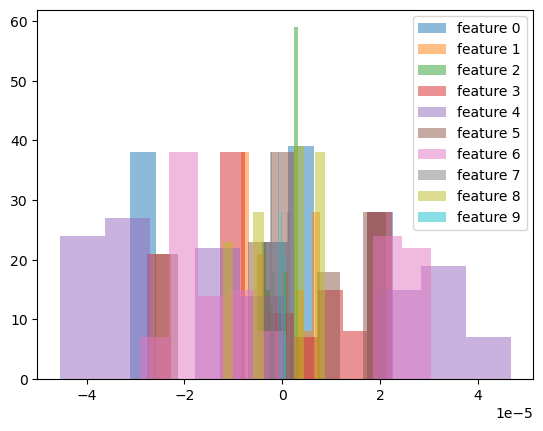

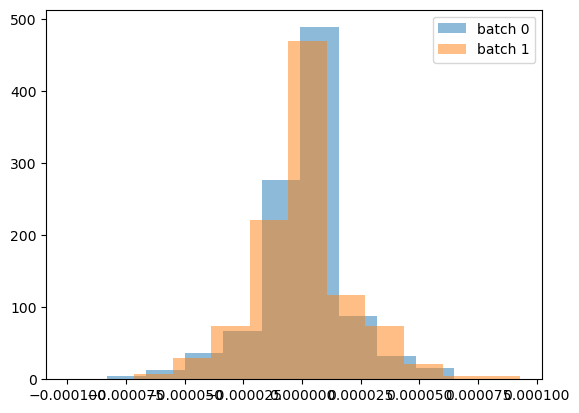

In [51]:
X = train_monitor.gradients['layers.norm_9'][0]
# plt.hist(X.flatten())
for f in range(10):
    plt.hist(X[:,f],label=f'feature {f}',alpha=0.5)
plt.legend()

plt.figure()
for b in [0,1]:
    plt.hist(X[b,:],label=f'batch {b}',alpha=0.5)
plt.legend()
X.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.gridspec import GridSpec

def plot_layer_metrics_lines(history, metric_name, is_train=True, save_path=None):
    """
    Create a line plot visualization with:
    - x-axis: Layer index (simple order of layers in the model)
    - multiple lines: one for each training step
    - line color: corresponds to the step (from early to late training)
    """
    prefix = "Training" if is_train else "Validation"
    metrics_history = history['training_metrics_history'] if is_train else history['validation_metrics_history']
    steps = history['step_history']
    
    # Get layer names in the order they appear in the dictionary
    layer_names = list(metrics_history.keys())
    
    # Filter out layers without the requested metric
    valid_layers = [layer for layer in layer_names if metric_name in metrics_history[layer]]
    
    # Check if we have layers to plot
    if not valid_layers:
        print(f"No valid layers found for {metric_name}!")
        return
    
    # Create figure with GridSpec to leave room for colorbar
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(1, 2, width_ratios=[20, 1])  # Main plot and colorbar
    ax = fig.add_subplot(gs[0])  # Main plot
    cax = fig.add_subplot(gs[1])  # Colorbar axes
    
    # Get colormap for steps
    cmap = matplotlib.colormaps['viridis']
    
    # Determine which steps to highlight
    if len(steps) > 10:
        # If we have many steps, only label a few of them for clarity
        highlight_indices = [0, len(steps)//4, len(steps)//2, 3*len(steps)//4, len(steps)-1]
    else:
        highlight_indices = range(len(steps))
    
    # Plot each step as a separate line
    for i, step in enumerate(steps):
        # Get metric values for this step across all layers
        values = [metrics_history[layer][metric_name][i] for layer in valid_layers]
        
        # Normalize step index for color mapping
        color = cmap(i / max(1, len(steps)-1))
        
        # Plot with varying linewidth and marker for highlighted steps
        if i in highlight_indices:
            ax.plot(range(len(valid_layers)), values, '-o', 
                   color=color, linewidth=2, markersize=6,
                   label=f'Step {step}')
        else:
            ax.plot(range(len(valid_layers)), values, '-', 
                   color=color, linewidth=1, alpha=0.5)
    
    # Set labels and title
    ax.set_xlabel('Layer Index (Forward Pass Order)')
    ax.set_ylabel(metric_name.replace('_', ' ').title())
    ax.set_title(f'{prefix} {metric_name.replace("_", " ").title()} Evolution Across Layers')
    
    # Add layer names as x tick labels
    short_names = [layer.split('.')[-1] if '.' in layer else layer for layer in valid_layers]
    ax.set_xticks(range(len(valid_layers)))
    ax.set_xticklabels(short_names, rotation=45, ha='right')
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='best')
    
    # Add colorbar to show step progression
    norm = plt.Normalize(min(steps), max(steps))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=cax, label='Training Steps')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}/lines_{prefix.lower()}_{metric_name}.png", dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_all_metrics_lines(history, save_path=None):
    """Plot line visualizations of all metrics"""
    # Create save directory if specified
    if save_path:
        import os
        os.makedirs(save_path, exist_ok=True)
        
    # Get all metrics
    metrics = ['dead_fraction', 'dup_fraction', 'eff_rank', 'stable_rank']
    
    # Plot training metrics
    for metric in metrics:
        plot_layer_metrics_lines(history, metric, is_train=True, save_path=save_path)
    
    # Plot validation metrics
    for metric in metrics:
        plot_layer_metrics_lines(history, metric, is_train=False, save_path=save_path)

# Alternative simpler version without a colorbar
def plot_layer_metrics_simple(history, metric_name, is_train=True, save_path=None):
    """
    Simpler version without colorbar - uses line styles to differentiate steps
    """
    prefix = "Training" if is_train else "Validation"
    metrics_history = history['training_metrics_history'] if is_train else history['validation_metrics_history']
    steps = history['step_history']
    
    # Get layer names in the order they appear in the dictionary
    layer_names = list(metrics_history.keys())
    
    # Filter out layers without the requested metric
    valid_layers = [layer for layer in layer_names if metric_name in metrics_history[layer]]
    
    if not valid_layers:
        print(f"No valid layers found for {metric_name}!")
        return
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Choose steps to plot (if too many)
    if len(steps) > 6:
        # Just select a few representative steps
        step_indices = [0, len(steps)//5, 2*len(steps)//5, 3*len(steps)//5, 4*len(steps)//5, len(steps)-1]
        selected_steps = [steps[i] for i in step_indices]
    else:
        step_indices = range(len(steps))
        selected_steps = steps
    
    # Different line styles and colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markers = ['o', 's', '^', 'D', 'x', '*', '+']
    
    # Plot each selected step
    for i, step_idx in enumerate(step_indices):
        step = steps[step_idx]
        values = [metrics_history[layer][metric_name][step_idx] for layer in valid_layers]
        
        plt.plot(range(len(valid_layers)), values, 
                 marker=markers[i % len(markers)],
                 color=colors[i % len(colors)], 
                 label=f'Step {step}')
    
    # Set labels and title
    plt.xlabel('Layer Index (Forward Pass Order)')
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.title(f'{prefix} {metric_name.replace("_", " ").title()} Evolution Across Layers')
    
    # Add layer names as x tick labels
    short_names = [layer.split('.')[-1] if '.' in layer else layer for layer in valid_layers]
    plt.xticks(range(len(valid_layers)), short_names, rotation=45, ha='right')
    
    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='best')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}/simple_{prefix.lower()}_{metric_name}.png", dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_all_metrics_simple(history, save_path=None):
    """Plot simplified line visualizations of all metrics"""
    # Create save directory if specified
    if save_path:
        import os
        os.makedirs(save_path, exist_ok=True)
        
    metrics = ['dead_fraction', 'dup_fraction', 'eff_rank', 'stable_rank']
    
    for metric in metrics:
        plot_layer_metrics_simple(history, metric, is_train=True, save_path=save_path)
        plot_layer_metrics_simple(history, metric, is_train=False, save_path=save_path)

# Example usage:
plot_all_metrics_lines(history, save_path='./results')  # With colorbar
# plot_all_metrics_simple(history, save_path='./results')  # Simpler version



# Create a directory for saving plots
results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

# Plot results
print("\nPlotting results...")
plot_training_curves(history, save_path=results_dir)

# Plot metrics evolution for all layers
plot_all_metrics(history, save_path=results_dir)

# Plot comparison of metrics between training and validation
plot_comparison_metrics(history, save_path=results_dir)

# Additional analysis comparing training vs validation metrics
print("\nComparing final training vs validation metrics:")